# Setting up the data for the model

In [5]:
# getting the os for path names and pandas to create the dataframe
import os
import pandas as pd

# getting the pathogen name in class and image path in path
dir0 = '/kaggle/input/plant-pathogens/pathogen'
classes = []
paths = []

# using for loop and filling the classes and paths list
# resulting lists will have the class and path of a sample at same index in both
# this fact will be used to create a daatframe
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        if not filename.endswith('.txt'):
            classes.append(dirname.split('/')[-1])
            paths.append(os.path.join(dirname, filename))

# creating the dataframe and checking the sample size and pathogen classes
data = pd.DataFrame(columns=['path', 'pathogen'])
data['path'] = paths
data['pathogen'] = classes
print(len(data))
print(data['pathogen'].unique())


176744
['fungus' 'bacteria' 'healthy' 'virus' 'pests']


In [6]:
# looking at how the dataframe actually looks like
data.head()

,path,pathogen
0,/kaggle/input/plant-pathogens/pathogen/fungus/...,fungus
1,/kaggle/input/plant-pathogens/pathogen/fungus/...,fungus
2,/kaggle/input/plant-pathogens/pathogen/fungus/...,fungus
3,/kaggle/input/plant-pathogens/pathogen/fungus/...,fungus
4,/kaggle/input/plant-pathogens/pathogen/fungus/...,fungus


# CNN model

In [7]:

from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

2024-05-28 10:51:46.088642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:51:46.088732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:51:46.244033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
from sklearn.model_selection import train_test_split

# First split the data into a training set and a temporary set using the 70:30 ratio
train_data, temp_data = train_test_split(data, test_size=0.6, random_state=42)

# Then split the temporary set into validation and test sets using the 50:50 ratio
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# now we have train.test and val as 6:2:2 ratio

# Create a training data generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col="path",
    y_col="pathogen",
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical')

# Create a validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col="path",
    y_col="pathogen",
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical')

# create a test data generator
# Create a validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col="path",
    y_col="pathogen",
    target_size=(64, 64),
    batch_size=8,
    class_mode='categorical')

Found 70697 validated image filenames belonging to 5 classes.
Found 53023 validated image filenames belonging to 5 classes.
Found 53023 validated image filenames belonging to 5 classes.


In [9]:
# Check distribution in training set
print("Training set:")
print(train_data['pathogen'].value_counts())

# Check distribution in validation set
print("\nValidation set:")
print(val_data['pathogen'].value_counts())

# Check distribution in test set
print("\nTest set:")
print(test_data['pathogen'].value_counts())

Training set:
pathogen
fungus      14509
healthy     14172
bacteria    14155
virus       14020
pests       13841
Name: count, dtype: int64

Validation set:
pathogen
fungus      10780
bacteria    10734
virus       10714
pests       10437
healthy     10358
Name: count, dtype: int64

Test set:
pathogen
fungus      10817
healthy     10604
virus       10557
bacteria    10534
pests       10512
Name: count, dtype: int64


In [10]:

class_indices = train_generator.class_indices

# This gives you a dictionary where the keys are your class (pathogen) names and the values are the corresponding categorical labels.

# To get the class names back from the categorical labels, you can create a reverse mapping:
reverse_mapping = {v: k for k, v in class_indices.items()}

print(reverse_mapping)


{0: 'bacteria', 1: 'fungus', 2: 'healthy', 3: 'pests', 4: 'virus'}


# Testing a simple cnn model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Input shape: 64x64 pixels with 3 channels
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  # Flatten the tensor output from the previous layer
    Dense(128, activation='relu'),
    Dense(len(data['pathogen'].unique()), activation='softmax')
])

# Compile your model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Define the early stopping criteria
earlystop = EarlyStopping(monitor='val_loss',  # performance measure to check
                          min_delta=0,  # minimum change to qualify as an improvement
                          patience=5,  # number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')  # direction of improvement is inferred automatically

# Adding callbacks to a list
callbacks_list = [earlystop]




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
# Train the simple model
history = model.fit(
    train_generator,
    validation_data=val_generator,  # add your validation data generator here
    epochs=30,
    callbacks=callbacks_list)  # pass your callbacks list here


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   4/8838 ━━━━━━━━━━━━━━━━━━━━ 5:14 36ms/step - accuracy: 0.3229 - loss: 1.6472 

I0000 00:00:1716893625.673783      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716893625.690443      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8831/8838 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5924 - loss: 1.0031

W0000 00:00:1716894522.175420      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1624s 183ms/step - accuracy: 0.5925 - loss: 1.0029 - val_accuracy: 0.7687 - val_loss: 0.6021
Epoch 2/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 981s 111ms/step - accuracy: 0.8039 - loss: 0.5134 - val_accuracy: 0.7890 - val_loss: 0.5557
Epoch 3/30
5271/8838 ━━━━━━━━━━━━━━━━━━━━ 3:54 66ms/step - accuracy: 0.8637 - loss: 0.3633

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1005s 114ms/step - accuracy: 0.8980 - loss: 0.2727 - val_accuracy: 0.8181 - val_loss: 0.5549
Epoch 5/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1035s 117ms/step - accuracy: 0.9272 - loss: 0.1953 - val_accuracy: 0.8265 - val_loss: 0.6437
Epoch 6/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 979s 111ms/step - accuracy: 0.9470 - loss: 0.1437 - val_accuracy: 0.8245 - val_loss: 0.6953
Epoch 7/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1029s 116ms/step - accuracy: 0.9576 - loss: 0.1186 - val_accuracy: 0.8204 - val_loss: 0.8256
Epoch 8/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1032s 117ms/step - accuracy: 0.9648 - loss: 0.0989 - val_accuracy: 0.8246 - val_loss: 0.8694
Epoch 8: early stopping


In [13]:
# Evaluate thye simple model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

6628/6628 ━━━━━━━━━━━━━━━━━━━━ 407s 61ms/step - accuracy: 0.8212 - loss: 0.8821
Test accuracy: 0.8246421217918396


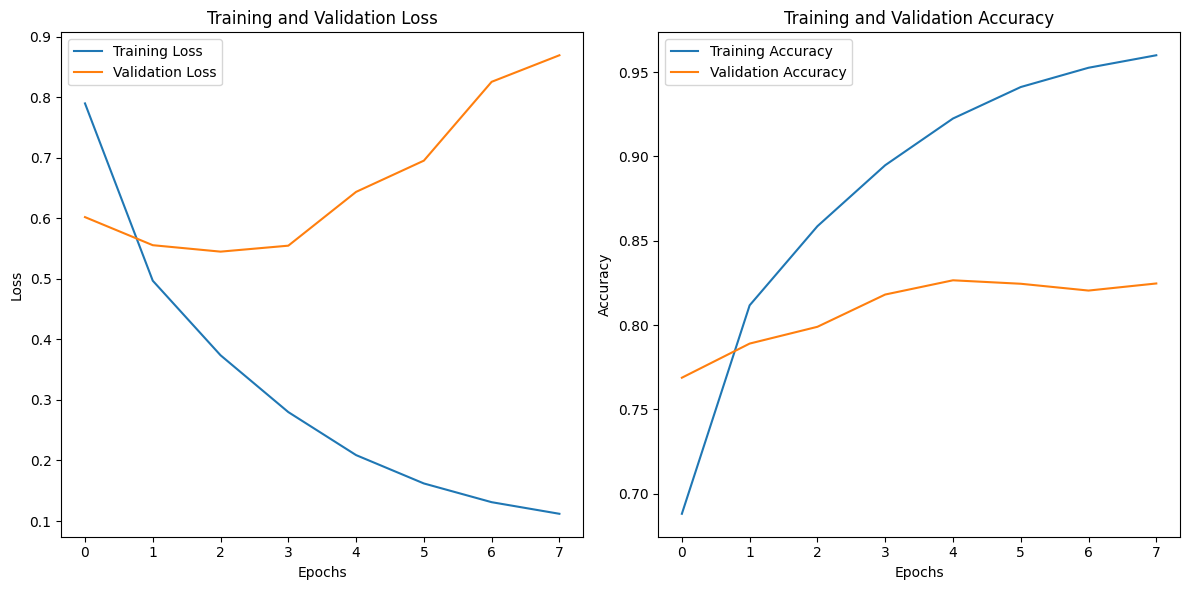

In [14]:
import matplotlib.pyplot as plt

# Assuming 'history' is the returned object from 'model.fit()'
history_dict = history.history

# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Get the model's predictions
predictions = model.predict(val_generator)



   1/6628 ━━━━━━━━━━━━━━━━━━━━ 40:19 365ms/step

W0000 00:00:1716902715.991367      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6628/6628 ━━━━━━━━━━━━━━━━━━━━ 404s 61ms/step


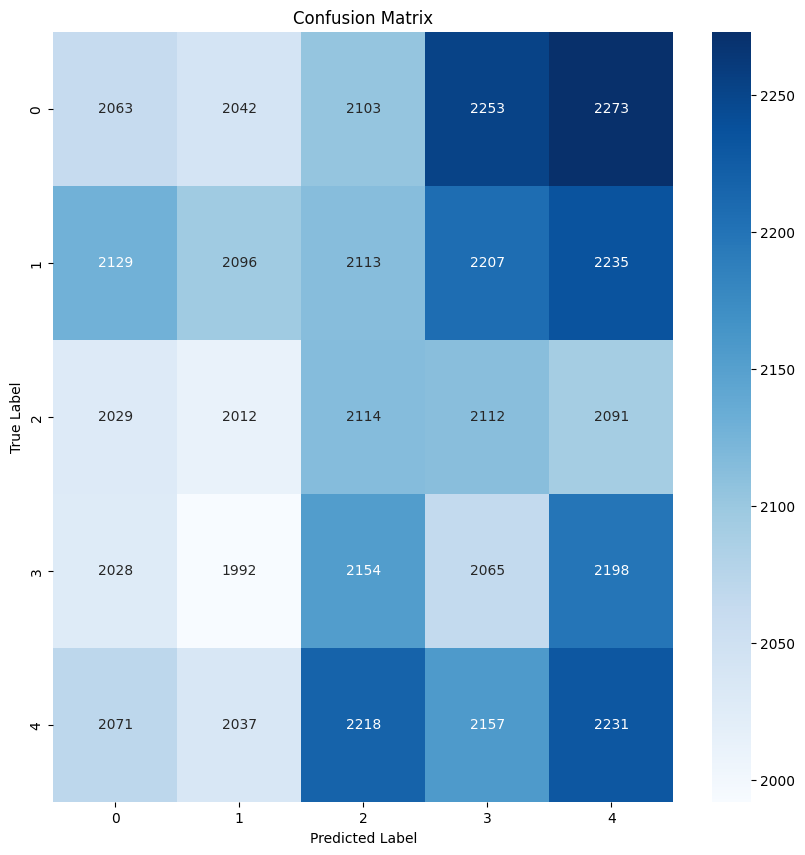

In [16]:
import numpy as np
y_pred = np.argmax(predictions, axis=1)

# Get the actual labels
y_true = val_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
print(reverse_mapping)

{0: 'bacteria', 1: 'fungus', 2: 'healthy', 3: 'pests', 4: 'virus'}


# testing a simpler model as the learning curves tend to overfit a bit

In [18]:
# Define the model
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # Input shape: 64x64 pixels with 3 channels
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  # Flatten the tensor output from the previous layer
    Dense(64, activation='relu'),
    Dense(len(data['pathogen'].unique()), activation='softmax')
])

# Compile your model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Train the simple model
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,  # add your validation data generator here
    epochs=30,
    callbacks=callbacks_list)  # pass your callbacks list here

Epoch 1/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 999s 113ms/step - accuracy: 0.3586 - loss: 1.4037 - val_accuracy: 0.6668 - val_loss: 0.8561
Epoch 2/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1069s 121ms/step - accuracy: 0.7070 - loss: 0.7564 - val_accuracy: 0.6565 - val_loss: 0.8818
Epoch 3/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1147s 130ms/step - accuracy: 0.7799 - loss: 0.5885 - val_accuracy: 0.7430 - val_loss: 0.7063
Epoch 4/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 974s 110ms/step - accuracy: 0.8252 - loss: 0.4758 - val_accuracy: 0.7395 - val_loss: 0.7453
Epoch 5/30
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 989s 112ms/step - accuracy: 0.8487 - loss: 0.4103 - val_accuracy: 0.7304 - val_loss: 0.8449
Epoch 5: early stopping


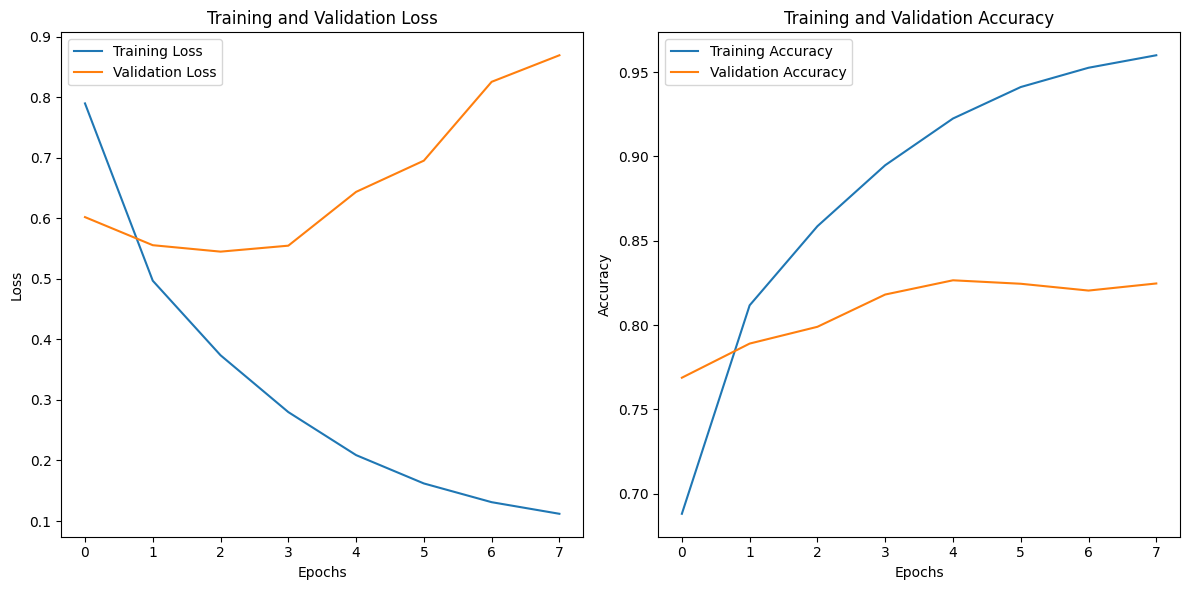

In [23]:
# Assuming 'history' is the returned object from 'model.fit()'
history_dict2 = history.history

# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_dict2['loss'], label='Training Loss')
plt.plot(history_dict2['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1,2,2)
plt.plot(history_dict2['accuracy'], label='Training Accuracy')
plt.plot(history_dict2['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
predictions2 = model2.predict(val_generator)

In [ ]:
y_pred2 = np.argmax(predictions2, axis=1)

# Get the actual labels
y_true2 = val_generator.classes

# Create the confusion matrix
cm2 = confusion_matrix(y_true2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()